Meeting with Jackie
PSTH -- Movment
spike raster divided by trial by color -- lick raster
-- ISI

Meeting with Yujin -- Correlation map of tongue to mrn brain areas

In [2]:
""" 
Potential Plans
1) Function to calculate correlation between one unit spiking and tongue acitivty
2) Generalize for all units over each trial
3) Create correlation map in the MRN

 --- maps for other brain areas -> correlation mapping between areas 
"""

""" 
Create preprocessing tool for susu dataset to be compatible with the current MATLAB viewing tool.

"""

' \nCreate preprocessing tool for susu dataset to be compatible with the current MATLAB viewing tool.\n\n'

In [3]:
"""
Import Libraries
"""

import zutils

import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import stats
import pandas as pd

from time import sleep
import os
from pynwb import NWBHDF5IO
import numpy as np
from allensdk.core.reference_space_cache import ReferenceSpaceCache

# Statistics modules
from scipy.stats import linregress
from datetime import datetime

In [4]:
"""
Load the Data -- Currently includes 1 session of data including recordings from L and R midbrain and L and R ALM
"""
# Data Folder
dataDir = 'C:\\Users\\zachl\\OneDrive\\BU_YEAR1\\Economo_Rotation\\data\\'

# File Parameters
sub = ['441666']
date = ['20190516']

# LOAD DATA
data = zutils.load_data(dataDir, sub, date)

# Get first session from Data
sub1 = data[0]

Loading data for sub-['441666']:['20190516'] from 
Data directory: C:\Users\zachl\OneDrive\BU_YEAR1\Economo_Rotation\data\
['sub-441666_ses-20190516T152922_behavior+ecephys+ogen.nwb']


In [5]:
""" 
Get Data Ready for Graphing
"""

# Save the Behavioral Data
movementDF = zutils.get_behavioral_timeseries(sub1)

# Get Unit Locations
unitDF = zutils.saveCCFCoordsAndRegion(sub1,'./','./',sub[0],date[0])


min 266.3749302995454


c:\Users\zachl\OneDrive\BU_YEAR1\Economo_Rotation\Susu_Data_Analysis\EphysDataAnalysis\zutils.py:205: RuntimeWarning: invalid value encountered in cast
  x = electrodes.x.data[:].astype(int) # ML in Allen CCF
c:\Users\zachl\OneDrive\BU_YEAR1\Economo_Rotation\Susu_Data_Analysis\EphysDataAnalysis\zutils.py:206: RuntimeWarning: invalid value encountered in cast
  y = electrodes.y.data[:].astype(int) # DV in Allen CCF
c:\Users\zachl\OneDrive\BU_YEAR1\Economo_Rotation\Susu_Data_Analysis\EphysDataAnalysis\zutils.py:207: RuntimeWarning: invalid value encountered in cast
  z = electrodes.z.data[:].astype(int) # AP in Allen CCF
100%|██████████| 1967/1967 [00:00<00:00, 3271.60it/s]


In [6]:
# Look at the unique regions that these units span
uniqueRegions = np.unique(unitDF["region"])
# print(uniqueRegions)

# We want to look at the Midbrain reticular nucleus
midbrainDF = unitDF[unitDF['region'].str.contains('.*Midbrain reticular nucleus.*', case=False, regex=True)]
# midbrainDF = unitDF[unitDF['region'].str.contains('.*colliculus.*', case=False, regex=True)]

In [7]:
unitsRegDF = midbrainDF
UoI = 30 # unit of interest

spikeTimes = midbrainDF["spike_times"]

spikeMatrix = []
for row in spikeTimes:
        spikeMatrix.append(row)

# Get Neural spiking data
spikeDF = zutils.get_firing_rate_from_spikes(spike_vec= spikeMatrix[UoI], binsize=50)  #ms
print(len(spikeDF))

59060


In [8]:
# Resample the neural data
# Set the 'timestamp' column as the index
spikeDF.set_index('TimeStampsIndex', inplace=True)

# Resample to 50ms intervals
resampled_df = spikeDF.resample('50L').mean()  # 'L' stands for milliseconds
print(len(resampled_df))

59061


In [9]:
# Resample the behavioral data
movementDF.set_index('TimeStampsIndex', inplace=True)
resampled_MovementDF = movementDF.resample('50L').mean()
print(len(movementDF))
print(len(resampled_MovementDF))

815719
59974


In [29]:
# Specify the number of zero rows you want to add
num_zeros = len(resampled_MovementDF) - len(resampled_df)

# Generate timestamps for the new rows (increasing from the last timestamp in original_df)
last_timestamp = resampled_df['TimeStamps'].iloc[-1]
new_timestamps = np.arange(last_timestamp + 0.05, last_timestamp + (num_zeros * 0.05) + 0.05, 0.05)

# Create a DataFrame with the specified number of rows of zeros and increasing timestamps
zero_data = {
    'SpikeRate': np.zeros(len(new_timestamps)),
    'TimeStamps': new_timestamps
}
zero_df = pd.DataFrame(zero_data)

# Concatenate the original DataFrame with the DataFrame containing zero measurements
neural_extended = pd.concat([resampled_df, zero_df], ignore_index=True)

# Delete last row of dataframe to correct size
neural_extended = neural_extended.drop(neural_extended.index[-1])

In [35]:
print(len(neural_extended))
print(len(resampled_MovementDF))
print(neural_extended.keys())
print(resampled_MovementDF.keys(
))

59974
59974
Index(['SpikeRate', 'TimeStamps'], dtype='object')
Index(['TimeStamps', 'TongueDist', 'NoseDist', 'JawDist'], dtype='object')


<Figure size 640x480 with 0 Axes>

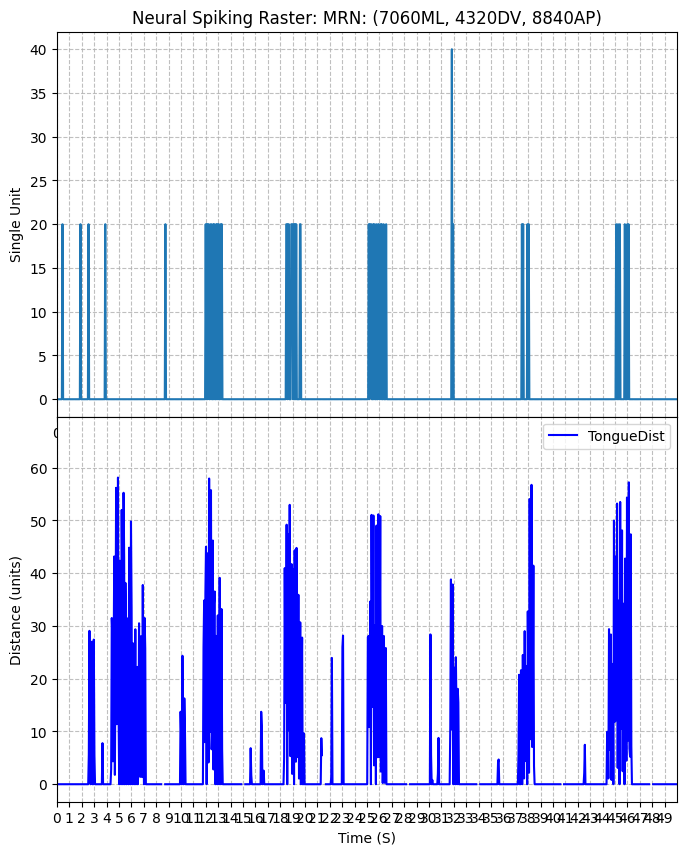

In [33]:
# midbrainDF = unitDF[unitDF['region'].str.contains('.*Midbrain reticular nucleus.*', case=False, regex=True)]
t0 = 0
tf = 50
reg = "MRN"
behavType = "TongueDist"


""" 
Prepare space for plotting
"""
unitsRegDF = midbrainDF
UoI = 15 # unit of interest

ml = unitsRegDF.iloc[UoI]["x"]
dv = unitsRegDF.iloc[UoI]["y"]
ap = unitsRegDF.iloc[UoI]["z"]

# Clear Existing Figure
plt.clf()

# Create a figure with multiple subplots
fig, axs = plt.subplots(2,1, figsize=(8, 10), sharex=False)

""" 
Plot the Spiking Data
"""
# Plot firing rates
axs[0].plot(resampled_df["TimeStamps"], resampled_df["SpikeRate"])


"""
Plot Movement Data
"""
# Plot the jaw distance
axs[1].plot(resampled_MovementDF["TimeStamps"], resampled_MovementDF["TongueDist"], color='b')


"""
Customizing the Plot Settings
"""
# Remove the x-axis from the first subplot
#axs[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Set the x-axis limits based on your data
axs[0].set_xlim(t0, tf)
axs[0].set_title(f"Neural Spiking Raster: {reg}: ({ml}ML, {dv}DV, {ap}AP)")
axs[0].set_xticks(range(t0,tf))
axs[1].set_xticks(range(t0,tf))

# Add labels and legend
axs[0].set_ylabel('Single Unit')

# Set xlim and ylim
axs[1].set_xlim(t0, tf)
#axs[1].set_ylim(0, max(JawVec+1))
# axs.set_ylim(0, 500)
# axs.legend(['Tongue Distance', 'Jaw Distance', 'Nose Distance'])

# Add labels
axs[1].set_xlabel('Time (S)')
axs[1].set_ylabel('Distance (units)')

# Add a grid to the second subplot
axs[0].grid(True, linestyle='--', alpha=0.8)
axs[1].grid(True, linestyle='--', alpha=0.8)
axs[1].legend([behavType])

# Adjust the spacing between subplots (bottom and top)
plt.subplots_adjust(hspace=-0)

# Show the figure
plt.show()

In [12]:
Behavioral_TimeStamps = sub1.acquisition["BehavioralTimeSeries"]["Camera0_side_TongueTracking"].timestamps[:]

In [13]:
Behavioral_TimeStamps

array([0.00000000e+00, 3.40000054e-03, 6.80000109e-03, ...,
       2.99865850e+03, 2.99866190e+03, 2.99866530e+03])

In [36]:
x = [1,2,3,4, 5]
y = [1,3,4,5,6]
reg_output = linregress(x, y)

In [41]:
reg_output

LinregressResult(slope=1.2000000000000002, intercept=0.1999999999999993, rvalue=0.9863939238321437, pvalue=0.001901274660196368, stderr=0.11547005383792505, intercept_stderr=0.38297084310253493)

In [ ]:
x = sub1.acquisition["BehavioralEvents"]["go_start_times"].timestamps[:]
# print(x)
print(len(x))

y = sub1.acquisition["BehavioralEvents"]["sample_start_times"].timestamps[:]
# print(y)
print(len(y))

z = sub1.acquisition["BehavioralEvents"]["right_lick_times"].timestamps[:]
# print(z)
print(len(z))

a = sub1.acquisition["BehavioralEvents"]["left_lick_times"].timestamps[:]
# print(a)
print(len(a))

439
451
1863
1655
